In [17]:
from typing import TypedDict, Annotated
from langgraph.graph import END, add_messages, StateGraph
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage
from dotenv import load_dotenv
from langchain_community.tools import TavilySearchResults
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

load_dotenv()


class BasicChatState(TypedDict):
    messages: Annotated[list, add_messages]


memory = MemorySaver()

llm = ChatGroq(model_name="llama-3.1-8b-instant")
search_tool = TavilySearchResults(max_results=4)
tools = [search_tool]
llm_with_tools = llm.bind_tools(tools=tools)


def model(state: BasicChatState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


def tools_router(state: BasicChatState):
    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
        return "tool_node"
    else:
        return "end"


tool_node = ToolNode(tools=tools)


graph = StateGraph(BasicChatState)
graph.add_node("model", model)
graph.add_node("tool_node", tool_node)
graph.set_entry_point("model")
graph.add_conditional_edges(
    "model",
    tools_router,
    {
        "tool_node": "tool_node",
        "end": END,
    },
)
graph.add_edge("tool_node", "model")

app = graph.compile(checkpointer=memory, interrupt_before=["tool_node"])

# while True:
#     user_input = input("User : ")
#     if user_input.lower() == "exit":
#         break
#     else:
#         result = app.invoke({"messages": [HumanMessage(content=user_input)]})
#         print(result["messages"][-1].content)

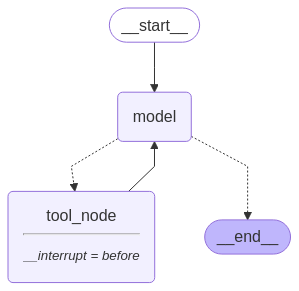

In [19]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [22]:
config = {"configurable": {"thread_id": 1}}

events = app.stream(
    {"messages": [HumanMessage(content="What is the current weather in Tokyo?")]},
    config=config,
    stream_mode="values",
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the current weather in Tokyo?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_a2vr)
 Call ID: call_a2vr
  Args:
    query: current weather in Tokyo


In [23]:
snapshot = app.get_state(config=config)
snapshot.next

('tool_node',)

In [24]:
events = app.stream(None, config, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_a2vr)
 Call ID: call_a2vr
  Args:
    query: current weather in Tokyo
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Weather for Tokyo, Japan - Time and Date", "url": "https://www.timeanddate.com/weather/japan/tokyo", "content": "Weather in Tokyo, Japan\n\nSunny.\n\nFeels Like: 66 °FForecast: 76 / 58 °FWind: 14 mph ↑ from South\n\nLocation: | Tokyo Heliport\nCurrent Time: | Apr 27, 2025 at 6:56:05 pm\nLatest Report: | Apr 27, 2025 at 4:00 pm\nVisibility: | 10 mi\nPressure: | 29.89 \"Hg\nHumidity: | 60%\nDew Point: | 52 °F\nUpcoming 5 hours\n\nNow | 7:00 pm | 8:00 pm | 9:00 pm | 10:00 pm | 11:00 pm\n |  |  |  |  | \n66 °F | 70 °F | 69 °F | 69 °F | 67 °F | 64 °F\nSee more hour-by-hour weather\n\nForecast for the next 48 hours [...] Humidity | 40% | 58% | 47% | 34% | 81% | 82% | 55%\n